
<h1><center> Modeling Notebook: ML for Next-Day Return </h1></center>

This notebook trains and evaluates ML models to predict next-day returns (regression) and next-day direction (classification) from engineered features built in the Feature Engineering notebook. It also includes a simple trading backtest and an optional bootstrap to quantify risk metrics of the strategy.

**Inputs**: `data/features.csv` (or `.parquet`) produced previously.
**Outputs**: metrics, plots, and saved models in `models/`.



# Imports

In [36]:

import os
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit, GroupKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor

# Optional: try LightGBM / XGBoost if available
_HAS_LGBM = False
_HAS_XGB  = False
try:
    from lightgbm import LGBMClassifier, LGBMRegressor
    _HAS_LGBM = True
except Exception:
    pass
try:
    from xgboost import XGBClassifier, XGBRegressor
    _HAS_XGB = True
except Exception:
    pass

# Misc
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
warnings.filterwarnings("ignore")

## 1) Load features

In [37]:

BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / "data"
MODELS_DIR = BASE_DIR / "models"
MODELS_DIR.mkdir(exist_ok=True)

feat_path_parquet =  "../data/features.parquet"
feat_path_csv     = "../data/features.csv"

feats = pd.read_csv(feat_path_csv)

# basic typing
feats['date'] = pd.to_datetime(feats['date'])
feats['ticker'] = feats['ticker'].astype(str)
feats = feats.sort_values(['ticker','date']).reset_index(drop=True)

print("Features shape:", feats.shape)
print("Columns (sample):", feats.columns[:20].tolist(), "...")

Features shape: (1673, 58)
Columns (sample): ['date', 'ticker', 'open', 'high', 'low', 'close', 'volume', 'aggregated_text', 'headline', 'summary', 'news_count', 'daily_return', 'log_return', 'vol_7d', 'vol_21d', 'vol_63d', 'mom_5d', 'mom_10d', 'mom_20d', 'sma_20'] ...


## 2) Targets and feature set
We will:
- Use `target_return` (regression) and `target_up` (classification)
- Exclude potential leakage columns and non-numerical text fields

In [38]:


exclude_cols = {
    'target_return','target_up','split','date','ticker',
    'aggregated_text','headline','summary'
}

num_cols = [c for c in feats.columns \
            if (c not in exclude_cols) and (np.issubdtype(feats[c].dtype, np.number))]

print("# numeric features:", len(num_cols))

# Train/valid split indicator created in the features notebook (80/20 per ticker)
train_idx = feats['split'].eq('train')
valid_idx = feats['split'].eq('valid')

# Datasets
X_train = feats.loc[train_idx, num_cols].copy()
X_valid = feats.loc[valid_idx, num_cols].copy()

# Targets
y_train_cls = feats.loc[train_idx, 'target_up'].astype(int)
y_valid_cls = feats.loc[valid_idx, 'target_up'].astype(int)

y_train_reg = feats.loc[train_idx, 'target_return'].astype(float)
y_valid_reg = feats.loc[valid_idx, 'target_return'].astype(float)

# Groups for potential grouped CV (by ticker)
train_groups = feats.loc[train_idx, 'ticker']

print(X_train.shape, X_valid.shape)

# numeric features: 50
(1337, 50) (336, 50)



## 3) Baselines
 - **Naive 0**: predict zero return (regression) and majority class (classification)
 - **Sign(prev return)**: predict direction = sign of `daily_return` (momentum baseline)


In [39]:

# Baseline regression: predict 0
y_pred_reg_base0 = np.zeros_like(y_valid_reg)

# Baseline classification: majority class in training
maj_class = int(y_train_cls.mode().iloc[0])
y_pred_cls_maj = np.full_like(y_valid_cls, fill_value=maj_class)

# Momentum baseline for direction: sign of today's return
valid_daily_return = feats.loc[valid_idx, 'daily_return']
y_pred_cls_mom = (valid_daily_return > 0).astype(int).values

print("Baselines -> MAE (reg=0):", mean_absolute_error(y_valid_reg, y_pred_reg_base0))
print("Baselines -> Acc (maj):", accuracy_score(y_valid_cls, y_pred_cls_maj))
print("Baselines -> Acc (momentum sign):", accuracy_score(y_valid_cls, y_pred_cls_mom))

Baselines -> MAE (reg=0): 0.01446570554315327
Baselines -> Acc (maj): 0.5505952380952381
Baselines -> Acc (momentum sign): 0.47619047619047616


## 4) Classification models
We'll train three classifiers with a robust scaler: 
 - Logistic Regression (L2)
 - Random Forest
 - Gradient Boosting (LightGBM/XGBoost if available, else HistGB)



Classification metrics (valid):
   Model  Accuracy  BalancedAcc      F1  ROC_AUC
0  Logit    0.5298       0.5322  0.5434   0.5163
2     GB    0.5238       0.5134  0.5876   0.4926
1     RF    0.5268       0.5149  0.5954   0.4910


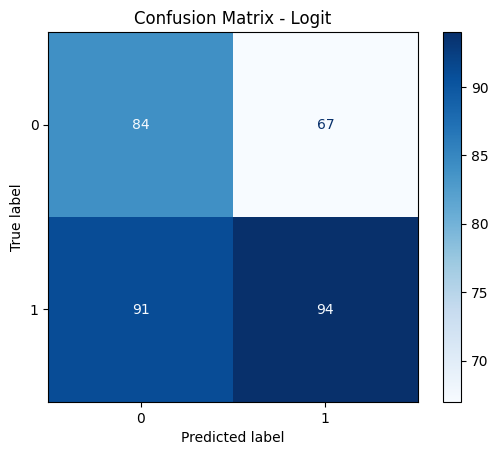

['/Users/mauricioaguasfonseca/Documents/Trabajos/S&P_Global/Prediction_StockPrices/notebooks/models/cls_Logit.joblib']

In [40]:
from joblib import dump
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# --- Clean infinities and NaNs ---
for X in (X_train, X_valid):
    X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Common imputer
imputer = SimpleImputer(strategy='median')

# 4.1 Logistic Regression (needs scaling)
logit_clf = Pipeline([
    ("imputer", imputer),
    ("scaler", RobustScaler()),
    ("clf", LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_STATE))
])
logit_clf.fit(X_train, y_train_cls)

# 4.2 Random Forest (tree-based, no scaling needed, but still needs imputation)
rf_clf = Pipeline([
    ("imputer", imputer),
    ("clf", RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_leaf=2,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        class_weight='balanced_subsample'
    ))
])
rf_clf.fit(X_train, y_train_cls)

# 4.3 Gradient Boosting
if _HAS_LGBM:
    gb_clf = Pipeline([
        ("imputer", imputer),
        ("clf", LGBMClassifier(
            n_estimators=800,
            learning_rate=0.03,
            max_depth=-1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=RANDOM_STATE
        ))
    ])
elif _HAS_XGB:
    gb_clf = Pipeline([
        ("imputer", imputer),
        ("clf", XGBClassifier(
            n_estimators=800,
            learning_rate=0.03,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            eval_metric='logloss'
        ))
    ])
else:
    gb_clf = Pipeline([
        ("imputer", imputer),
        ("clf", HistGradientBoostingClassifier(
            max_depth=None,
            learning_rate=0.05,
            max_iter=600,
            random_state=RANDOM_STATE
        ))
    ])

gb_clf.fit(X_train, y_train_cls)

# --- Evaluation ---
models_cls = {"Logit": logit_clf, "RF": rf_clf, "GB": gb_clf}

cls_metrics = []
for name, model in models_cls.items():
    proba = model.predict_proba(X_valid)[:, 1] if hasattr(model, 'predict_proba') else model.predict(X_valid)
    pred  = (proba >= 0.5).astype(int)
    acc   = accuracy_score(y_valid_cls, pred)
    bacc  = balanced_accuracy_score(y_valid_cls, pred)
    f1    = f1_score(y_valid_cls, pred)
    roc   = roc_auc_score(y_valid_cls, proba)
    cls_metrics.append([name, acc, bacc, f1, roc])

cls_df = pd.DataFrame(cls_metrics, columns=['Model','Accuracy','BalancedAcc','F1','ROC_AUC']).sort_values('ROC_AUC', ascending=False)
print("\nClassification metrics (valid):")
print(cls_df.round(4))

# Confusion matrix for best model
best_cls_name = cls_df.iloc[0]['Model']
best_cls = models_cls[best_cls_name]
best_proba = best_cls.predict_proba(X_valid)[:, 1] if hasattr(best_cls,'predict_proba') else best_cls.predict(X_valid)
best_pred  = (best_proba >= 0.5).astype(int)
cm = confusion_matrix(y_valid_cls, best_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title(f"Confusion Matrix - {best_cls_name}")
plt.show()

# Save
dump(best_cls, MODELS_DIR / f"cls_{best_cls_name}.joblib")


## 5) Regression models
 - Ridge, Lasso (with scaling)
 - Random Forest Regressor
 - Gradient Boosting Regressor (LightGBM/XGBoost if available, else HistGB)

In [41]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from joblib import dump

# --- Clean X: replace inf with NaN ---
for X in (X_train, X_valid):
    X.replace([np.inf, -np.inf], np.nan, inplace=True)

# --- Ensure y has no NaNs (due to target_return shift) ---
mask_y = y_train_reg.notna()
X_train_reg = X_train.loc[mask_y].copy()
y_train_reg_clean = y_train_reg.loc[mask_y].astype(float)

# Optional: drop columns with all-NaN or constant variance (training only)
good_cols = []
for c in X_train_reg.columns:
    col = X_train_reg[c]
    if col.notna().any() and (col.std(skipna=True) not in (0, np.nan)):
        good_cols.append(c)

X_train_reg = X_train_reg[good_cols]
X_valid_reg = X_valid[good_cols]

print(f"# reg features kept: {len(good_cols)}")

# --- Common imputer ---
imputer_med = SimpleImputer(strategy='median')

# Pipelines
ridge_reg = Pipeline([
    ("imputer", imputer_med),
    ("scaler", StandardScaler()),
    ("reg", Ridge(alpha=1.0, random_state=RANDOM_STATE))
])

lasso_reg = Pipeline([
    ("imputer", imputer_med),
    ("scaler", StandardScaler()),
    ("reg", Lasso(alpha=5e-4, random_state=RANDOM_STATE, max_iter=5000))
])

rf_reg = Pipeline([
    ("imputer", imputer_med),
    ("reg", RandomForestRegressor(
        n_estimators=600,
        max_depth=None,
        min_samples_leaf=2,
        n_jobs=-1,
        random_state=RANDOM_STATE
    ))
])

if _HAS_LGBM:
    gb_reg = Pipeline([
        ("imputer", imputer_med),
        ("reg", LGBMRegressor(
            n_estimators=1200,
            learning_rate=0.03,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=RANDOM_STATE
        ))
    ])
elif _HAS_XGB:
    gb_reg = Pipeline([
        ("imputer", imputer_med),
        ("reg", XGBRegressor(
            n_estimators=1200,
            learning_rate=0.03,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            objective='reg:squarederror'
        ))
    ])
else:
    # HistGB puede manejar NaNs, pero mantenemos imputación para consistencia
    gb_reg = Pipeline([
        ("imputer", imputer_med),
        ("reg", HistGradientBoostingRegressor(
            max_depth=None, learning_rate=0.05, max_iter=800, random_state=RANDOM_STATE
        ))
    ])

models_reg = {"Ridge": ridge_reg, "Lasso": lasso_reg, "RF": rf_reg, "GB": gb_reg}

reg_rows = []
for name, model in models_reg.items():
    model.fit(X_train_reg, y_train_reg_clean)
    pred = model.predict(X_valid_reg)

    mae = mean_absolute_error(y_valid_reg, pred)
    rmse = mean_squared_error(y_valid_reg, pred, squared=False)
    r2   = r2_score(y_valid_reg, pred)
    hit  = (np.sign(pred) == np.sign(y_valid_reg)).mean()  # directional hit rate
    reg_rows.append([name, mae, rmse, r2, hit])

reg_df = pd.DataFrame(reg_rows, columns=['Model','MAE','RMSE','R2','HitRate']).sort_values('RMSE')
print("\nRegression metrics (valid):")
print(reg_df.round(5))

best_reg_name = reg_df.iloc[0]['Model']
best_reg = models_reg[best_reg_name]
dump(best_reg, MODELS_DIR / f"reg_{best_reg_name}.joblib")


# reg features kept: 45

Regression metrics (valid):
   Model      MAE     RMSE       R2  HitRate
1  Lasso  0.01436  0.02331 -0.00038  0.54167
0  Ridge  0.01486  0.02351 -0.01773  0.52679
2     RF  0.01564  0.02458 -0.11253  0.51190
3     GB  0.01639  0.02613 -0.25724  0.48810


['/Users/mauricioaguasfonseca/Documents/Trabajos/S&P_Global/Prediction_StockPrices/notebooks/models/reg_Lasso.joblib']


 ## 6) Permutation Importance (validation set)
 For the best classifier & regressor

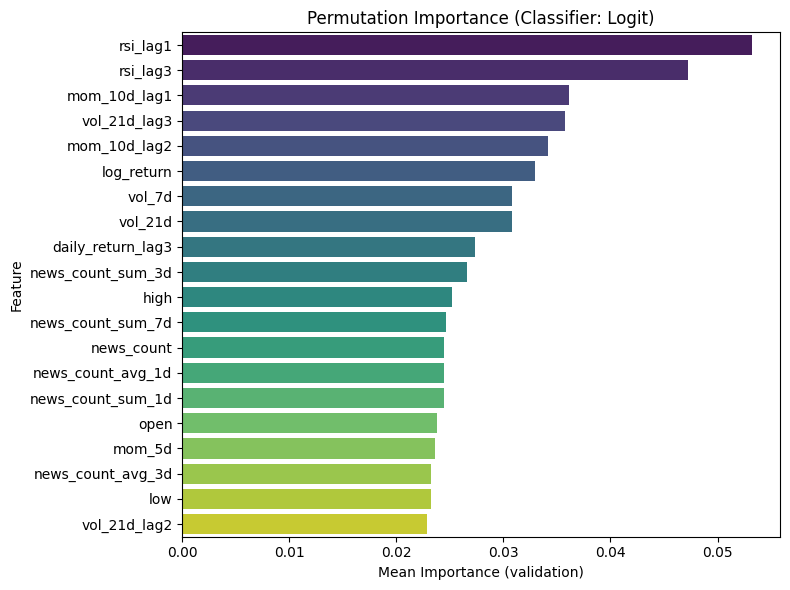

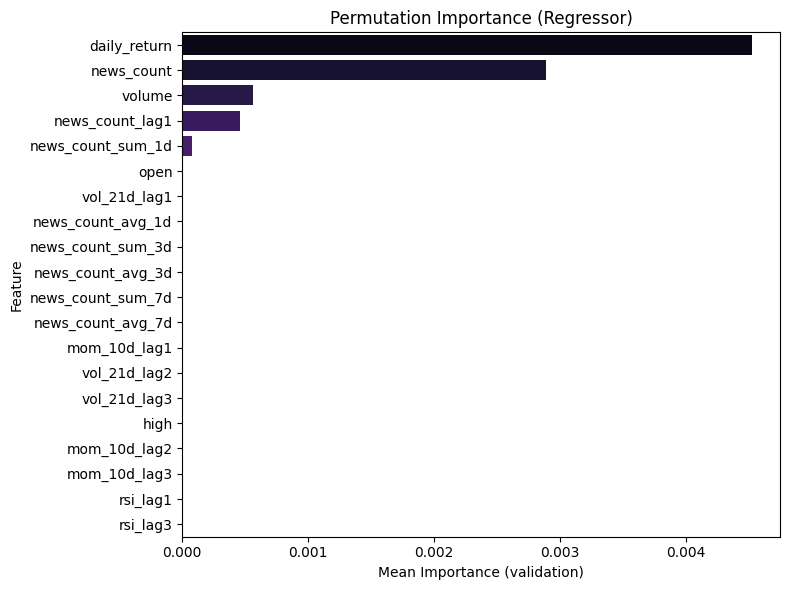

In [42]:
from sklearn.inspection import permutation_importance

pi_results = {}

# ----- CLASSIFIER -----
# Asegura las mismas columnas y orden que en el fit del clasificador
cls_feature_names = list(X_train.columns)         # columnas usadas en el fit de los clasificadores
Xv_cls = X_valid.reindex(columns=cls_feature_names)

pi_cls = permutation_importance(
    best_cls, Xv_cls, y_valid_cls,
    n_repeats=15, random_state=RANDOM_STATE, n_jobs=-1
)
pi_cls_df = (pd.DataFrame({
    'feature': cls_feature_names,
    'importance': pi_cls.importances_mean
})
.sort_values('importance', ascending=False)
.head(20))

pi_results['cls'] = pi_cls_df

plt.figure(figsize=(8,6))
sns.barplot(y='feature', x='importance', data=pi_cls_df, palette='viridis')
plt.title(f"Permutation Importance (Classifier: {best_cls_name})")
plt.xlabel('Mean Importance (validation)')
plt.ylabel('Feature')
plt.tight_layout(); plt.show()


# ----- REGRESSOR -----
# MUY IMPORTANTE: usar las columnas EXACTAS del entrenamiento del regresor
reg_feature_names = list(X_train_reg.columns)     # guardadas cuando limpiaste NaNs/constantes
Xv_reg = X_valid_reg.reindex(columns=reg_feature_names)

pi_reg = permutation_importance(
    best_reg, Xv_reg, y_valid_reg,
    n_repeats=15, random_state=RANDOM_STATE, n_jobs=-1
)
pi_reg_df = (pd.DataFrame({
    'feature': reg_feature_names,
    'importance': pi_reg.importances_mean
})
.sort_values('importance', ascending=False)
.head(20))

pi_results['reg'] = pi_reg_df

plt.figure(figsize=(8,6))
sns.barplot(y='feature', x='importance', data=pi_reg_df, palette='magma')
plt.title("Permutation Importance (Regressor)")
plt.xlabel('Mean Importance (validation)')
plt.ylabel('Feature')
plt.tight_layout(); plt.show()


## 7) Simple trading backtest (validation period)
 Strategy:
 - Use best classifier's probability. Go **long** if p(up) >= 0.55, **short** if <= 0.45, else **flat**.
 - Realized next-day return is `target_return`.
 - Equal-weight over tickers each day. Apply transaction costs when position changes.

Backtest (validation):
{'Annualized Return': 0.1003, 'Annualized Vol': 0.1102, 'Sharpe': 0.922, 'Max Drawdown': -0.0548, 'Hit Rate': 0.562}


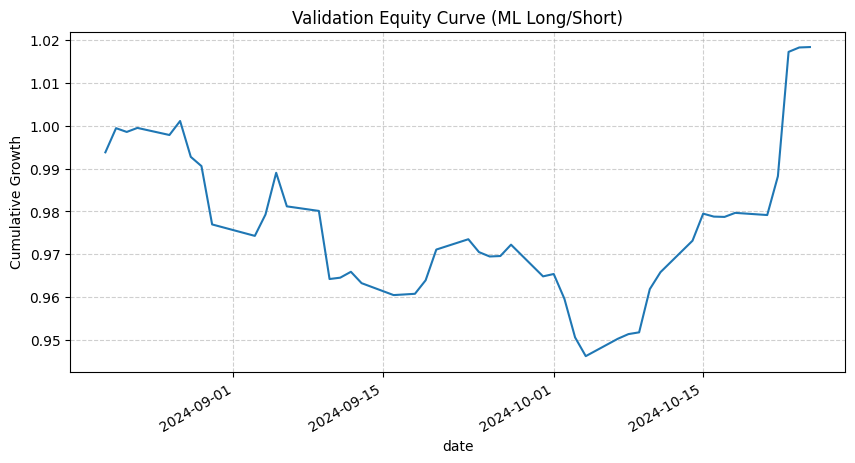

In [43]:

# Build validation frame with predictions
valid_frame = feats.loc[valid_idx, ['date','ticker','target_return']].copy()
valid_frame['proba_up'] = best_proba

# Signals: long = +1, short = -1, flat = 0
upper, lower = 0.55, 0.45
valid_frame['signal'] = 0
valid_frame.loc[valid_frame['proba_up'] >= upper, 'signal'] = 1
valid_frame.loc[valid_frame['proba_up'] <= lower, 'signal'] = -1

# Sort and compute position changes by ticker (for transaction costs)
valid_frame = valid_frame.sort_values(['ticker','date'])
valid_frame['prev_signal'] = valid_frame.groupby('ticker')['signal'].shift(1).fillna(0)
valid_frame['turnover'] = (valid_frame['signal'] - valid_frame['prev_signal']).abs()

# Daily PnL per ticker
tc_bps = 5  # 5 bps per signal change
cost = tc_bps / 10000.0
valid_frame['pnl'] = valid_frame['signal'] * valid_frame['target_return'] - cost * valid_frame['turnover']

# Aggregate to daily portfolio (equal-weight across tickers present)
daily_port = (valid_frame.groupby(['date'])
                         .agg(port_ret=('pnl','mean'), n_ticks=('ticker','nunique'))
                         .reset_index())

# Performance metrics
def sharpe(series, periods=252):
    mu = series.mean() * periods
    sigma = series.std(ddof=0) * np.sqrt(periods)
    return mu / sigma if sigma != 0 else np.nan

def max_drawdown(returns):
    curve = (1 + returns).cumprod()
    roll_max = curve.cummax()
    dd = (curve - roll_max) / roll_max
    return dd.min()

ann_return = (1 + daily_port['port_ret']).prod() ** (252/len(daily_port)) - 1
ann_vol = daily_port['port_ret'].std(ddof=0) * np.sqrt(252)
sharpe_ratio = sharpe(daily_port['port_ret'])
mdd = max_drawdown(daily_port['port_ret'])
hit_rate = (daily_port['port_ret'] > 0).mean()

print("Backtest (validation):")
print({
    'Annualized Return': round(ann_return,4),
    'Annualized Vol': round(ann_vol,4),
    'Sharpe': round(sharpe_ratio,3),
    'Max Drawdown': round(mdd,4),
    'Hit Rate': round(hit_rate,3)
})

plt.figure(figsize=(10,5))
(1 + daily_port.set_index('date')['port_ret']).cumprod().plot()
plt.title("Validation Equity Curve (ML Long/Short)")
plt.ylabel("Cumulative Growth")
plt.grid(True, ls='--', alpha=0.6)
plt.show()

 ## 8) Bootstrap the strategy returns (validation)
 A simple block bootstrap to estimate the uncertainty of Sharpe and MDD.


Bootstrap Sharpe: mean=-0.178, 5%=-4.772, 95%=4.462
Bootstrap MDD:    mean=-0.052, 5%=-0.094, 95%=-0.022


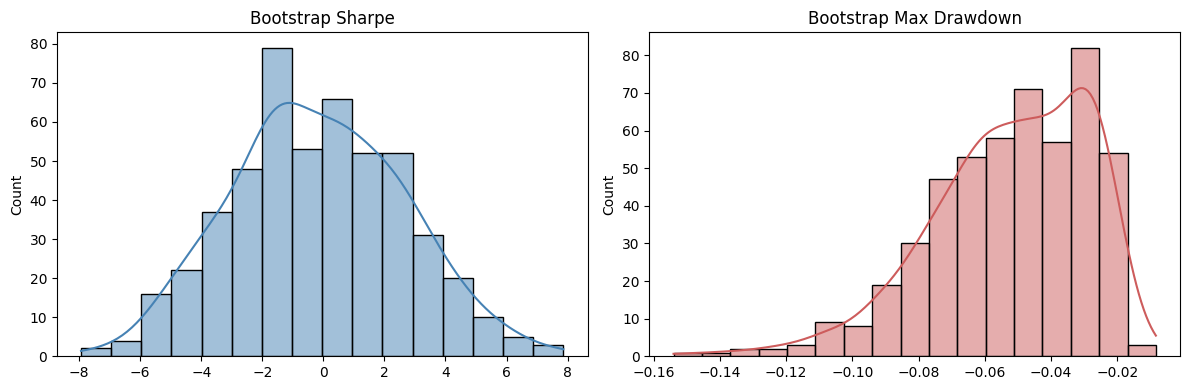

In [44]:


def block_bootstrap(series, block=5, n_sims=1000, seed=RANDOM_STATE):
    rng = np.random.default_rng(seed)
    T = len(series)
    idx = np.arange(T)
    sims = []
    for _ in range(n_sims):
        sampled = []
        while len(sampled) < T:
            start = rng.integers(0, max(1, T - block))
            sampled.extend(idx[start:start+block])
        sampled = sampled[:T]
        sims.append(series.iloc[sampled].reset_index(drop=True))
    return sims

# Run (set n_sims modestly to keep it light)
bootstrap_series = block_bootstrap(daily_port['port_ret'], block=5, n_sims=500)
sharpe_sims = [sharpe(s) for s in bootstrap_series]
mdd_sims    = [max_drawdown(s) for s in bootstrap_series]

print(f"Bootstrap Sharpe: mean={np.mean(sharpe_sims):.3f}, 5%={np.percentile(sharpe_sims,5):.3f}, 95%={np.percentile(sharpe_sims,95):.3f}")
print(f"Bootstrap MDD:    mean={np.mean(mdd_sims):.3f}, 5%={np.percentile(mdd_sims,5):.3f}, 95%={np.percentile(mdd_sims,95):.3f}")

plt.figure(figsize=(12,4))
plt.subplot(1,2,1); sns.histplot(sharpe_sims, kde=True, color='steelblue'); plt.title('Bootstrap Sharpe');
plt.subplot(1,2,2); sns.histplot(mdd_sims, kde=True, color='indianred'); plt.title('Bootstrap Max Drawdown');
plt.tight_layout(); plt.show()

## 9) Save validation predictions (for audit)

In [45]:
# %%
valid_out = valid_frame.copy()
valid_out = valid_out[['date','ticker','proba_up','signal','target_return','pnl']]
valid_out.to_csv(MODELS_DIR / 'validation_predictions.csv', index=False)
print("Saved:", MODELS_DIR / 'validation_predictions.csv')

Saved: /Users/mauricioaguasfonseca/Documents/Trabajos/S&P_Global/Prediction_StockPrices/notebooks/models/validation_predictions.csv



## 10) Improvements
 - Consider hyperparameter tuning via GridSearchCV (TimeSeriesSplit within the training period only).
 - Try more informative thresholds (optimize on training): search thresholds that maximize Sharpe.
 - Add cross-ticker features (e.g., market/sector indices) and improved sentiment (FinBERT).
 - Evaluate transaction cost sensitivity (0–20 bps) and leverage constraints.


 ## 4b) Hyperparameter tuning (Classification) — GridSearchCV with TimeSeriesSplit
 We tune the gradient boosting classifier (LGBM/XGB if available; otherwise HistGB).


In [46]:

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Build CV: time-aware (no shuffling)
tscv = TimeSeriesSplit(n_splits=5)

if _HAS_LGBM:
    base_clf = LGBMClassifier(random_state=RANDOM_STATE)
    param_grid_clf = {
        'n_estimators': [400, 800, 1200],
        'learning_rate': [0.02, 0.05, 0.1],
        'num_leaves': [31, 63, 127],
        'subsample': [0.7, 0.9],
        'colsample_bytree': [0.7, 0.9],
    }
elif _HAS_XGB:
    base_clf = XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1, eval_metric='logloss')
    param_grid_clf = {
        'n_estimators': [400, 800, 1200],
        'learning_rate': [0.02, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.7, 0.9],
        'colsample_bytree': [0.7, 0.9],
    }
else:
    base_clf = HistGradientBoostingClassifier(random_state=RANDOM_STATE)
    param_grid_clf = {
        'learning_rate': [0.02, 0.05, 0.1],
        'max_depth': [None, 6, 12],
        'max_iter': [400, 800, 1200],
        'l2_regularization': [0.0, 0.1, 1.0],
    }

clf_search = GridSearchCV(
    estimator=base_clf,
    param_grid=param_grid_clf,
    scoring='roc_auc',
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

clf_search.fit(X_train, y_train_cls)
print("Best CLF params:", clf_search.best_params_)
print("Best CV ROC_AUC:", round(clf_search.best_score_, 4))

# Evaluate on validation
proba_tuned = clf_search.predict_proba(X_valid)[:,1] if hasattr(clf_search.best_estimator_, 'predict_proba') else clf_search.predict(X_valid)
pred_tuned = (proba_tuned >= 0.5).astype(int)
print("Tuned CLF ROC_AUC (valid):", round(roc_auc_score(y_valid_cls, proba_tuned), 4))
print("Tuned CLF Accuracy (valid):", round(accuracy_score(y_valid_cls, pred_tuned), 4))

# Replace best classifier if better
if roc_auc_score(y_valid_cls, proba_tuned) > cls_df.iloc[0]['ROC_AUC']:
    best_cls_name = 'GB_tuned'
    best_cls = clf_search.best_estimator_
    best_proba = proba_tuned
    dump(best_cls, MODELS_DIR / f"cls_{best_cls_name}.joblib")
    print("Replaced best classifier with tuned GB.")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best CLF params: {'l2_regularization': 0.0, 'learning_rate': 0.02, 'max_depth': 6, 'max_iter': 800}
Best CV ROC_AUC: 0.5209
Tuned CLF ROC_AUC (valid): 0.4797
Tuned CLF Accuracy (valid): 0.4732


In [47]:



# %% [markdown]
# ## 5b) Hyperparameter tuning (Regression) — GridSearchCV with TimeSeriesSplit
# We tune the gradient boosting regressor (LGBM/XGB if available; otherwise HistGB).

# %%
if _HAS_LGBM:
    base_reg = LGBMRegressor(random_state=RANDOM_STATE)
    param_grid_reg = {
        'n_estimators': [600, 1000, 1400],
        'learning_rate': [0.02, 0.05, 0.1],
        'num_leaves': [31, 63, 127],
        'subsample': [0.7, 0.9],
        'colsample_bytree': [0.7, 0.9],
    }
elif _HAS_XGB:
    base_reg = XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1, objective='reg:squarederror')
    param_grid_reg = {
        'n_estimators': [600, 1000, 1400],
        'learning_rate': [0.02, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.7, 0.9],
        'colsample_bytree': [0.7, 0.9],
    }
else:
    base_reg = HistGradientBoostingRegressor(random_state=RANDOM_STATE)
    param_grid_reg = {
        'learning_rate': [0.02, 0.05, 0.1],
        'max_depth': [None, 6, 12],
        'max_iter': [400, 800, 1200],
        'l2_regularization': [0.0, 0.1, 1.0],
    }

reg_search = GridSearchCV(
    estimator=base_reg,
    param_grid=param_grid_reg,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

reg_search.fit(X_train, y_train_reg)
print("Best REG params:", reg_search.best_params_)
print("Best CV RMSE:", round(-reg_search.best_score_, 6))

# Evaluate on validation
pred_reg_tuned = reg_search.predict(X_valid)
mae_tuned = mean_absolute_error(y_valid_reg, pred_reg_tuned)
rmse_tuned = mean_squared_error(y_valid_reg, pred_reg_tuned, squared=False)
r2_tuned = r2_score(y_valid_reg, pred_reg_tuned)
hit_tuned = (np.sign(pred_reg_tuned) == np.sign(y_valid_reg)).mean()
print({
    'MAE_valid': round(mae_tuned,6),
    'RMSE_valid': round(rmse_tuned,6),
    'R2_valid': round(r2_tuned,6),
    'HitRate_valid': round(hit_tuned,4)
})

# Replace best regressor if better
if rmse_tuned < reg_df.iloc[0]['RMSE']:
    best_reg_name = 'GB_tuned'
    best_reg = reg_search.best_estimator_
    dump(best_reg, MODELS_DIR / f"reg_{best_reg_name}.joblib")
    print("Replaced best regressor with tuned GB.")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best REG params: {'l2_regularization': 0.1, 'learning_rate': 0.02, 'max_depth': 6, 'max_iter': 400}
Best CV RMSE: 0.024557
{'MAE_valid': 0.015855, 'RMSE_valid': 0.025306, 'R2_valid': -0.179033, 'HitRate_valid': 0.4851}


In [48]:



# %% [markdown]
# ## 7b) Threshold optimization (training-only)
# Find the classification probability threshold that maximizes training Sharpe, then apply to validation.

# %%
# Build training predictions for threshold search
train_proba = best_cls.predict_proba(X_train)[:,1] if hasattr(best_cls,'predict_proba') else best_cls.predict(X_train)
train_frame = feats.loc[train_idx, ['date','ticker','target_return']].copy()
train_frame['proba_up'] = train_proba

# grid of thresholds
thr_grid = np.linspace(0.45, 0.65, 21)

best_thr, best_sharpe = 0.5, -np.inf
for thr in thr_grid:
    sig = np.where(train_frame['proba_up']>=thr, 1, np.where(train_frame['proba_up']<=1-thr, -1, 0))
    pnl = sig * feats.loc[train_idx, 'target_return'].values
    s = pd.Series(pnl)
    mu = s.mean()*252
    sigma = s.std(ddof=0)*np.sqrt(252)
    sharpe_val = mu/sigma if sigma>0 else -np.inf
    if sharpe_val > best_sharpe:
        best_sharpe, best_thr = sharpe_val, thr

print(f"Best training Sharpe threshold: {best_thr:.3f} (Sharpe={best_sharpe:.3f})")

# Recompute validation signals with optimized threshold
valid_frame['signal'] = 0
valid_frame.loc[valid_frame['proba_up'] >= best_thr, 'signal'] = 1
valid_frame.loc[valid_frame['proba_up'] <= 1-best_thr, 'signal'] = -1

# Recompute validation PnL and equity
valid_frame = valid_frame.sort_values(['ticker','date'])
valid_frame['prev_signal'] = valid_frame.groupby('ticker')['signal'].shift(1).fillna(0)
valid_frame['turnover'] = (valid_frame['signal'] - valid_frame['prev_signal']).abs()
valid_frame['pnl'] = valid_frame['signal'] * valid_frame['target_return'] - cost * valid_frame['turnover']

daily_port_opt = (valid_frame.groupby(['date'])
                              .agg(port_ret=('pnl','mean'))
                              .reset_index())

ann_return_opt = (1 + daily_port_opt['port_ret']).prod() ** (252/len(daily_port_opt)) - 1
ann_vol_opt = daily_port_opt['port_ret'].std(ddof=0) * np.sqrt(252)
sharpe_ratio_opt = ann_return_opt / ann_vol_opt if ann_vol_opt>0 else np.nan

print("Validation (optimized threshold):", {
    'Annualized Return': round(ann_return_opt,4),
    'Annualized Vol': round(ann_vol_opt,4),
    'Sharpe': round(sharpe_ratio_opt,3)
})


Best training Sharpe threshold: 0.540 (Sharpe=2.679)
Validation (optimized threshold): {'Annualized Return': 0.156, 'Annualized Vol': 0.1182, 'Sharpe': 1.319}


 ## 11) Persist best models & experiment log
 Save the (potentially tuned) best classifier and regressor, along with
 their feature lists, params, and validation metrics for reproducibility.

In [51]:

# %%
import json
from datetime import datetime
from joblib import dump

MODELS_DIR.mkdir(exist_ok=True)

# ---- Helper to safely get model params (works for pipelines) ----
def get_model_params(model):
   
    try:
        params = model.get_params()
        # Convertir a string los objetos no serializables
        for k, v in params.items():
            try:
                json.dumps(v)  # test si es serializable
            except (TypeError, OverflowError):
                params[k] = str(v)
        return params
    except Exception as e:
        return {"error": str(e), "repr": str(model)}


# ---- Choose best classifier ----
# If you ran GridSearch, variables `best_cls_name`, `best_cls`, `best_proba` may have been updated.
# Otherwise, fall back to the previously computed best from `cls_df`/`models_cls`.
if 'best_cls' not in globals():
    best_cls_name = cls_df.iloc[0]['Model']
    best_cls = models_cls[best_cls_name]
    # recompute proba with aligned columns
    Xv_cls = X_valid.reindex(columns=cls_feature_names)
    best_proba = best_cls.predict_proba(Xv_cls)[:,1] if hasattr(best_cls,'predict_proba') else best_cls.predict(Xv_cls)

best_pred = (best_proba >= 0.5).astype(int)

cls_metrics_summary = {
    'Accuracy': float(accuracy_score(y_valid_cls, best_pred)),
    'BalancedAcc': float(balanced_accuracy_score(y_valid_cls, best_pred)),
    'F1': float(f1_score(y_valid_cls, best_pred)),
    'ROC_AUC': float(roc_auc_score(y_valid_cls, best_proba)),
}

# ---- Choose best regressor ----
if 'best_reg' not in globals():
    best_reg_name = reg_df.iloc[0]['Model']
    best_reg = models_reg[best_reg_name]

# Aligned validation matrix for regression
Xv_reg = X_valid_reg.reindex(columns=reg_feature_names)
reg_pred = best_reg.predict(Xv_reg)

reg_metrics_summary = {
    'MAE': float(mean_absolute_error(y_valid_reg, reg_pred)),
    'RMSE': float(mean_squared_error(y_valid_reg, reg_pred, squared=False)),
    'R2': float(r2_score(y_valid_reg, reg_pred)),
    'HitRate': float((np.sign(reg_pred) == np.sign(y_valid_reg)).mean()),
}

# ---- Save artifacts ----
ts = datetime.utcnow().strftime('%Y-%m-%dT%H-%M-%SZ')

# Classifier
cls_path = MODELS_DIR / f"best_classifier_{best_cls_name}_{ts}.joblib"
cls_meta_path = MODELS_DIR / f"best_classifier_{best_cls_name}_{ts}.json"
cls_feat_path = MODELS_DIR / f"cls_feature_names_{ts}.json"

dump(best_cls, cls_path)
json.dump({
    'model_name': str(best_cls),
    'alias': best_cls_name,
    'created_utc': ts,
    'metrics_valid': cls_metrics_summary,
    'params': get_model_params(best_cls),
}, open(cls_meta_path, 'w'))
json.dump(cls_feature_names, open(cls_feat_path, 'w'))

print("Saved classifier:", cls_path)
print("Saved classifier meta:", cls_meta_path)
print("Saved classifier features:", cls_feat_path)

# Regressor
reg_path = MODELS_DIR / f"best_regressor_{best_reg_name}_{ts}.joblib"
reg_meta_path = MODELS_DIR / f"best_regressor_{best_reg_name}_{ts}.json"
reg_feat_path = MODELS_DIR / f"reg_feature_names_{ts}.json"

dump(best_reg, reg_path)
json.dump({
    'model_name': str(best_reg),
    'alias': best_reg_name,
    'created_utc': ts,
    'metrics_valid': reg_metrics_summary,
    'params': get_model_params(best_reg),
}, open(reg_meta_path, 'w'))
json.dump(reg_feature_names, open(reg_feat_path, 'w'))

print("Saved regressor:", reg_path)
print("Saved regressor meta:", reg_meta_path)
print("Saved regressor features:", reg_feat_path)

Saved classifier: /Users/mauricioaguasfonseca/Documents/Trabajos/S&P_Global/Prediction_StockPrices/notebooks/models/best_classifier_Logit_2025-08-21T23-41-14Z.joblib
Saved classifier meta: /Users/mauricioaguasfonseca/Documents/Trabajos/S&P_Global/Prediction_StockPrices/notebooks/models/best_classifier_Logit_2025-08-21T23-41-14Z.json
Saved classifier features: /Users/mauricioaguasfonseca/Documents/Trabajos/S&P_Global/Prediction_StockPrices/notebooks/models/cls_feature_names_2025-08-21T23-41-14Z.json
Saved regressor: /Users/mauricioaguasfonseca/Documents/Trabajos/S&P_Global/Prediction_StockPrices/notebooks/models/best_regressor_Lasso_2025-08-21T23-41-14Z.joblib
Saved regressor meta: /Users/mauricioaguasfonseca/Documents/Trabajos/S&P_Global/Prediction_StockPrices/notebooks/models/best_regressor_Lasso_2025-08-21T23-41-14Z.json
Saved regressor features: /Users/mauricioaguasfonseca/Documents/Trabajos/S&P_Global/Prediction_StockPrices/notebooks/models/reg_feature_names_2025-08-21T23-41-14Z.js


## 12) Append experiment log (CSV)
 Logs one row with key metadata for easy comparison across runs.

In [52]:


# %%
log_row = {
    'timestamp_utc': ts,
    'cls_alias': best_cls_name,
    'cls_acc': cls_metrics_summary['Accuracy'],
    'cls_balanced_acc': cls_metrics_summary['BalancedAcc'],
    'cls_f1': cls_metrics_summary['F1'],
    'cls_roc_auc': cls_metrics_summary['ROC_AUC'],
    'reg_alias': best_reg_name,
    'reg_mae': reg_metrics_summary['MAE'],
    'reg_rmse': reg_metrics_summary['RMSE'],
    'reg_r2': reg_metrics_summary['R2'],
    'reg_hit': reg_metrics_summary['HitRate'],
    'n_features_cls': len(cls_feature_names),
    'n_features_reg': len(reg_feature_names),
}

log_path = MODELS_DIR / 'experiment_log.csv'
try:
    pd.DataFrame([log_row]).to_csv(log_path, mode='a', header=not log_path.exists(), index=False)
    print("Appended experiment log:", log_path)
except Exception as e:
    print("Could not append experiment log:", e)

# %% [markdown]
# ## 13) Quick reload test (sanity check)
# Ensure the saved models can be reloaded and scored with the stored feature sets.

# %%
from joblib import load

# Reload classifier and score
cls_loaded = load(cls_path)
Xv_cls_loaded = X_valid.reindex(columns=json.load(open(cls_feat_path)))
proba_loaded = cls_loaded.predict_proba(Xv_cls_loaded)[:,1] if hasattr(cls_loaded,'predict_proba') else cls_loaded.predict(Xv_cls_loaded)
print("Reloaded CLS ROC_AUC (valid):", round(roc_auc_score(y_valid_cls, proba_loaded), 4))

# Reload regressor and score
reg_loaded = load(reg_path)
Xv_reg_loaded = X_valid_reg.reindex(columns=json.load(open(reg_feat_path)))
pred_loaded = reg_loaded.predict(Xv_reg_loaded)
print("Reloaded REG RMSE (valid):", round(mean_squared_error(y_valid_reg, pred_loaded, squared=False), 6))


Appended experiment log: /Users/mauricioaguasfonseca/Documents/Trabajos/S&P_Global/Prediction_StockPrices/notebooks/models/experiment_log.csv
Reloaded CLS ROC_AUC (valid): 0.5163
Reloaded REG RMSE (valid): 0.02331


In [53]:
# %% [markdown]
# ## 13) Quick reload test (sanity check)
# Ensure the saved models can be reloaded and scored with the stored feature sets.

# %%
from joblib import load

# Reload classifier and score
cls_loaded = load(cls_path)
Xv_cls_loaded = X_valid.reindex(columns=json.load(open(cls_feat_path)))
proba_loaded = cls_loaded.predict_proba(Xv_cls_loaded)[:,1] if hasattr(cls_loaded,'predict_proba') else cls_loaded.predict(Xv_cls_loaded)
print("Reloaded CLS ROC_AUC (valid):", round(roc_auc_score(y_valid_cls, proba_loaded), 4))

# Reload regressor and score
reg_loaded = load(reg_path)
Xv_reg_loaded = X_valid_reg.reindex(columns=json.load(open(reg_feat_path)))
pred_loaded = reg_loaded.predict(Xv_reg_loaded)
print("Reloaded REG RMSE (valid):", round(mean_squared_error(y_valid_reg, pred_loaded, squared=False), 6))


Reloaded CLS ROC_AUC (valid): 0.5163
Reloaded REG RMSE (valid): 0.02331


# # 📊 Final Report — Model Results & Trading Backtest

In [55]:
# %% Bootstrap Simulation for Robustness
n_boot = 500
rng = np.random.default_rng(RANDOM_STATE)

boot_sharpes = []
boot_drawdowns = []

returns = daily_port_opt['port_ret'].values

for _ in range(n_boot):
    sample = rng.choice(returns, size=len(returns), replace=True)
    s = pd.Series(sample)

    mu = s.mean() * 252
    sigma = s.std(ddof=0) * np.sqrt(252)
    sharpe_val = mu / sigma if sigma > 0 else np.nan
    boot_sharpes.append(sharpe_val)

    # drawdown
    wealth = (1 + s).cumprod()
    dd = (wealth / wealth.cummax() - 1).min()
    boot_drawdowns.append(dd)


=== Clasificación (Validation) ===


,Model,Accuracy,BalancedAcc,F1,ROC_AUC
0,Logit,0.5298,0.5322,0.5434,0.5163
2,GB,0.5238,0.5134,0.5876,0.4926
1,RF,0.5268,0.5149,0.5954,0.4910



=== Regresión (Validation) ===


,Model,MAE,RMSE,R2,HitRate
1,Lasso,0.014361,0.023310,-0.000378,0.541667
0,Ridge,0.014862,0.023511,-0.017725,0.526786
2,RF,0.015644,0.024582,-0.112528,0.511905
3,GB,0.016390,0.026132,-0.257241,0.488095


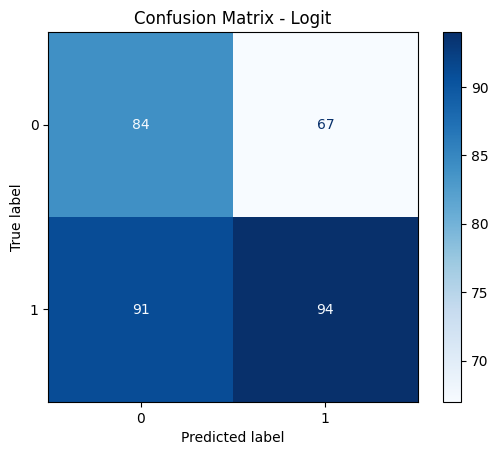

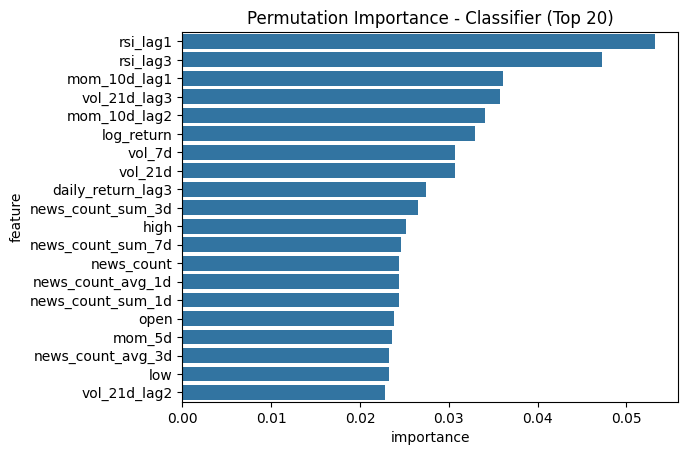

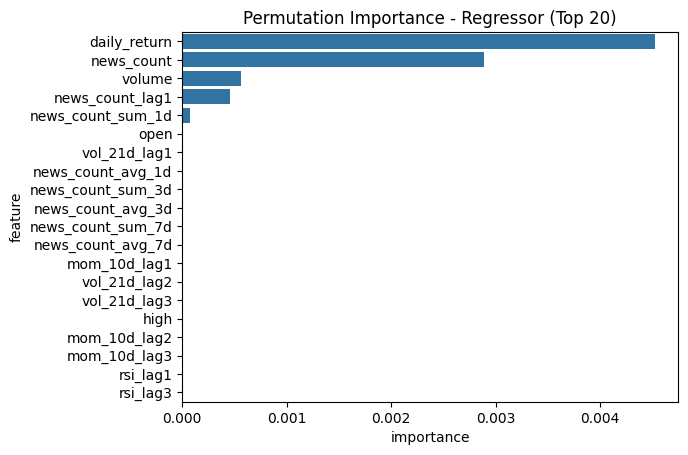


=== Validation Metrics (Optimized Threshold) ===
{'Annualized Return': 0.156, 'Annualized Vol': 0.1182, 'Sharpe': 1.319}


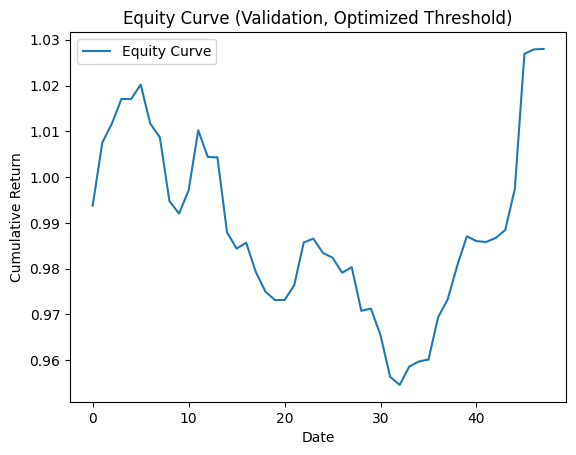

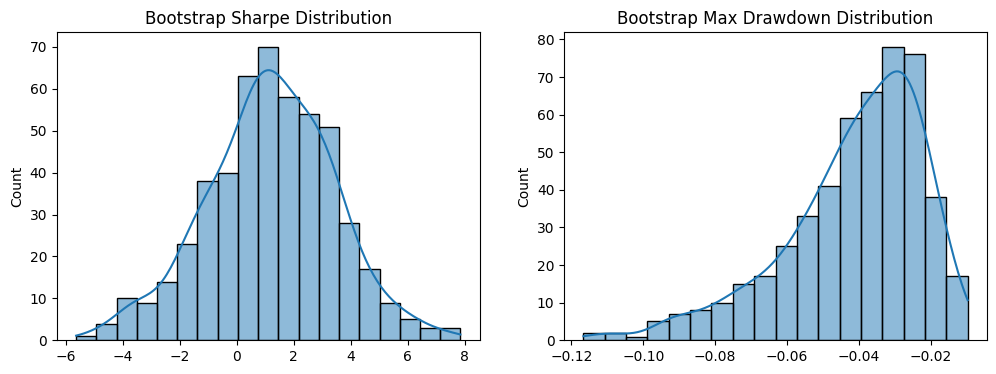


Best Classifier Params: {'l2_regularization': 0.0, 'learning_rate': 0.02, 'max_depth': 6, 'max_iter': 800}
Best Classifier CV ROC_AUC: 0.5209

Best Regressor Params: {'l2_regularization': 0.1, 'learning_rate': 0.02, 'max_depth': 6, 'max_iter': 400}
Best Regressor CV RMSE: 0.024557


In [56]:
# %% [markdown]
# # 📊 Final Report — Model Results & Trading Backtest

# %%
import seaborn as sns
import matplotlib.pyplot as plt

# === 1. Resumen de Rendimiento de Modelos ===
print("=== Clasificación (Validation) ===")
try:
    display(cls_df.round(4))
except:
    print("cls_df no disponible")

print("\n=== Regresión (Validation) ===")
try:
    display(reg_df.round(6))
except:
    print("reg_df no disponible")

# === 2. Matriz de Confusión del Mejor Clasificador ===
try:
    cm = confusion_matrix(y_valid_cls, best_pred)
    ConfusionMatrixDisplay(cm).plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {best_cls_name}")
    plt.show()
except:
    print("No confusion matrix available.")

# === 3. Importancia de Permutación ===
try:
    sns.barplot(data=pi_cls_df, x="importance", y="feature")
    plt.title("Permutation Importance - Classifier (Top 20)")
    plt.show()
except:
    print("pi_cls_df no disponible")

try:
    sns.barplot(data=pi_reg_df, x="importance", y="feature")
    plt.title("Permutation Importance - Regressor (Top 20)")
    plt.show()
except:
    print("pi_reg_df no disponible")

# === 4. Backtest de Estrategia ===
try:
    print("\n=== Validation Metrics (Optimized Threshold) ===")
    print({
        'Annualized Return': round(ann_return_opt,4),
        'Annualized Vol': round(ann_vol_opt,4),
        'Sharpe': round(sharpe_ratio_opt,3)
    })

    plt.plot((1+daily_port_opt['port_ret']).cumprod(), label="Equity Curve")
    plt.title("Equity Curve (Validation, Optimized Threshold)")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.show()
except:
    print("Backtest metrics not available.")

# === 5. Bootstrap Analysis ===
try:
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    sns.histplot(boot_sharpes, kde=True, ax=axes[0])
    axes[0].set_title("Bootstrap Sharpe Distribution")
    sns.histplot(boot_drawdowns, kde=True, ax=axes[1])
    axes[1].set_title("Bootstrap Max Drawdown Distribution")
    plt.show()
except:
    print("Bootstrap results not available.")

# === 6. Resultados de GridSearch (si corriste tuning) ===
try:
    print("\nBest Classifier Params:", clf_search.best_params_)
    print("Best Classifier CV ROC_AUC:", round(clf_search.best_score_, 4))
except:
    print("Classifier tuning not available.")

try:
    print("\nBest Regressor Params:", reg_search.best_params_)
    print("Best Regressor CV RMSE:", round(-reg_search.best_score_, 6))
except:
    print("Regressor tuning not available.")
